In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
ds = xr.open_dataset("../data/critical_1d.nc")

In [12]:
tol = 0.01
ds['critical'] = (1. - tol < ds['match']) & (ds['match'] < 1. + tol)
ds['critical'].attrs = {'tolerance': tol}

(-5, 5)

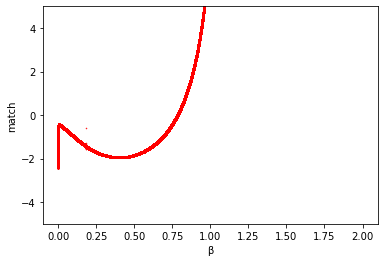

In [17]:
ds['match'].sel(β=ds['β']).plot(marker='.', markersize=1., color='r', linewidth=0.)
plt.ylim([-5,5])

Found vlow beta
Found low beta
Found high beta


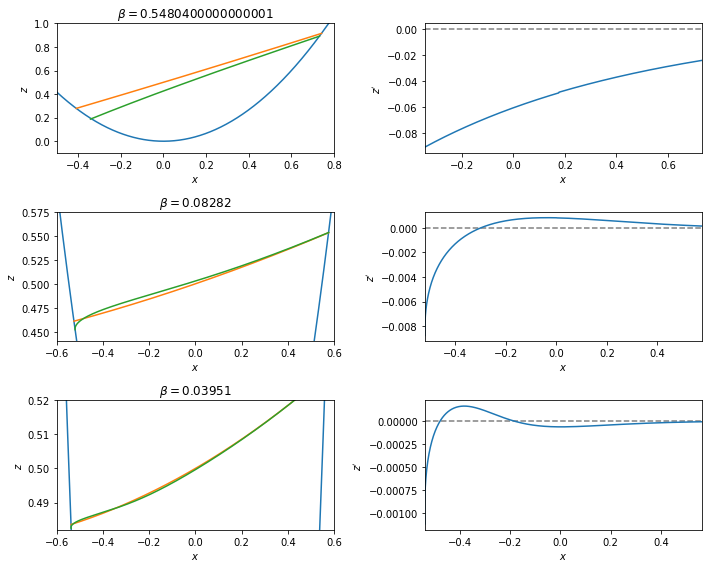

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))

# Example of critical flow

dx = 0.0015

r = 0.6
x = np.arange(-1,1+dx,dx)
h0 = 0
h = h0 + x**2/r

alpha = -1.65
gamma = 0.5

nbeta = 100000
dbeta = 1./nbeta
betas = np.arange(0,1.,dbeta)

match = np.zeros_like(betas)
Q = np.zeros_like(match)

lowbeta = False
highbeta = False
vlowbeta = False
for ii in range(1,nbeta):
    beta = betas[ii]

    d = alpha*x**2+beta*x+gamma
    d[d+h<h] = np.nan

    a = (beta - np.sqrt(beta**2-4*alpha*gamma))/(2*alpha)
    b = (- beta - np.sqrt(beta**2-4*alpha*gamma))/(2*alpha)

    x = np.arange(-a,b+dx,dx)
    nx = np.size(x)

    xpl = np.zeros(np.size(x))
    xpr = np.zeros(np.size(x))

    zpl = np.zeros(np.size(x))
    zpr = np.zeros(np.size(x))

    h = h0 + x**2/r
    s = 2*x/r
    sx = 2/r+np.zeros_like(s)
    d = alpha*x**2+beta*x+gamma
    v = 2*(alpha+1./r)*x+beta
    ddx = 2*alpha*x+beta

    xpl[0]=1
    zpl[0]=s[0]*xpl[0]

    # from left
    for i in range(np.int(np.size(xpl)/2)+1):
        if i==0:
            xpl[i+1] = xpl[i]+dx*(0.5/ddx[i]*(s[i]**2/v[i]**2 + sx[i])*xpl[i] + zpl[i]/v[i]**2)
            zpl[i+1] = zpl[i]+dx*(v[i]*0.5/ddx[i]*(s[i]**2/v[i]**2 + sx[i])*xpl[i])                   
        else:
            xpl[i+1]=xpl[i]+dx*((s[i]/d[i])*xpl[i]+1/d[i]*(d[i]/v[i]**2-1)*zpl[i])
            zpl[i+1]=zpl[i]+dx*(s[i]*v[i]/d[i]*xpl[i]-v[i]/d[i]*zpl[i])

    xpr[-1]=1
    zpr[-1]=s[-1]*xpr[-1]

    # from right
    for j in range(np.int(np.size(xpl)/2)+1):
        i = nx-(j+1)
        if j==0:
            xpr[i-1] = xpr[i]-dx*(0.5/ddx[i]*(s[i]**2/v[i]**2 + sx[i])*xpr[i] + zpr[i]/v[i]**2)
            zpr[i-1] = zpr[i]-dx*(v[i]*0.5/ddx[i]*(s[i]**2/v[i]**2 + sx[i])*xpr[i])                   
        else:
            xpr[i-1]=xpr[i]-dx*((s[i]/d[i])*xpr[i]+1/d[i]*(d[i]/v[i]**2-1)*zpr[i])
            zpr[i-1]=zpr[i]-dx*(s[i]*v[i]/d[i]*xpr[i]-v[i]/d[i]*zpr[i])

    # Redo shooting but scaled
    xpr[-1]=xpl[np.int(nx/2)]/xpr[np.int(nx/2)]
    zpr[-1]=s[-1]*xpr[-1]

    # from right
    for j in range(np.int(np.size(xpl)/2)+1):
        i = nx-(j+1)
        if j==0:
            xpr[i-1] = xpr[i]-dx*(0.5/ddx[i]*(s[i]**2/v[i]**2 + sx[i])*xpr[i] + zpr[i]/v[i]**2)
            zpr[i-1] = zpr[i]-dx*(v[i]*0.5/ddx[i]*(s[i]**2/v[i]**2 + sx[i])*xpr[i])                   
        else:
            xpr[i-1]=xpr[i]-dx*((s[i]/d[i])*xpr[i]+1/d[i]*(d[i]/v[i]**2-1)*zpr[i])
            zpr[i-1]=zpr[i]-dx*(s[i]*v[i]/d[i]*xpr[i]-v[i]/d[i]*zpr[i])

    match[ii] = zpl[np.int(nx/2)]/zpr[np.int(nx/2)]
    Q[ii] = np.nansum(v*d*dx)
    
    tol = 0.01
    if (match[ii] < 1+tol) and (match[ii] > 1-tol):
        if beta > 0.5 and not highbeta:
            print('Found high beta')
            sca = 15.
            zt = np.append(zpl[:np.size(zpl)//2],zpr[np.size(zpr)//2:])/sca
            xt = np.append(xpl[:np.size(zpl)//2],xpr[np.size(zpr)//2:])/sca

            plt.subplot(3,2,1)
            plt.title(r'$\beta = {}$'.format(beta))
            xx = np.arange(-1,1+dx,dx)
            hh = h0 + xx**2/r
            plt.plot(xx,hh)
            plt.plot(x,h+d)
            plt.plot(x+xt,h+d+zt)
            plt.xlim([-0.5,0.8])
            plt.ylim([-0.1,1.0])
            plt.xlabel(r'$x$')
            plt.ylabel(r'$z$')
            
            plt.subplot(3,2,2)
            plt.plot(x+xt,(x+xt)*0.,'k--',alpha=0.5)
            plt.plot(x+xt,zt)
            plt.xlim([(x+xt)[0],(x+xt)[-1]])
            
            plt.xlabel(r'$x$')
            plt.ylabel(r'$z^{\prime}$')
            highbeta = True
            
        if beta > 0.05 and not lowbeta:
            print('Found low beta')
            sca = 200.
            zt = np.append(zpl[:np.size(zpl)//2],zpr[np.size(zpr)//2:])/sca
            xt = np.append(xpl[:np.size(zpl)//2],xpr[np.size(zpr)//2:])/sca

            plt.subplot(3,2,3)
            plt.title(r'$\beta = {}$'.format(beta))
            xx = np.arange(-1,1+dx,dx)
            hh = h0 + xx**2/r
            plt.plot(xx,hh)
            plt.plot(x,h+d)
            plt.plot(x+xt,h+d+zt)
            plt.xlim([-0.6,0.6])
            plt.ylim([0.44,0.575])
            plt.xlabel(r'$x$')
            plt.ylabel(r'$z$')
            
            plt.subplot(3,2,4)
            plt.plot(x+xt,(x+xt)*0.,'k--',alpha=0.5)
            plt.plot(x+xt,zt)
            plt.xlim([(x+xt)[0],(x+xt)[-1]])
            
            plt.xlabel(r'$x$')
            plt.ylabel(r'$z^{\prime}$')
            lowbeta = True
            
        if beta > 0.03 and not vlowbeta:
            print('Found vlow beta')
            sca = 1600.
            zt = np.append(zpl[:np.size(zpl)//2],zpr[np.size(zpr)//2:])/sca
            xt = np.append(xpl[:np.size(zpl)//2],xpr[np.size(zpr)//2:])/sca

            plt.subplot(3,2,5)
            plt.title(r'$\beta = {}$'.format(beta))
            xx = np.arange(-1,1+dx,dx)
            hh = h0 + xx**2/r
            plt.plot(xx,hh)
            plt.plot(x,h+d)
            plt.plot(x+xt,h+d+zt)
            plt.xlim([-0.6,0.6])
            plt.ylim([0.482,0.52])
            plt.xlabel('$x$')
            plt.ylabel('$z$')
            
            plt.subplot(3,2,6)
            plt.plot(x+xt,(x+xt)*0.,'k--',alpha=0.5)
            plt.plot(x+xt,zt)
            plt.xlim([(x+xt)[0],(x+xt)[-1]])
            plt.xlabel(r'$x$')
            plt.ylabel(r'$z^{\prime}$')
            vlowbeta = True
            
plt.tight_layout()
plt.savefig('stationary_perturbations.png',dpi=200,bbox_inches='tight')

Text(0.5,0,'$\\beta$')

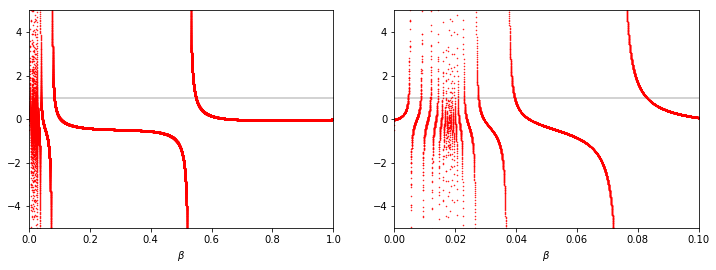

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

tol=0.02
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.fill_between([0,1],[1-tol,1-tol],[1+tol,1+tol],color="lightgrey")
plt.plot(betas,match,"r.",markersize=1,alpha=1.0)
plt.ylim([-5,5])
plt.xlim([0,1])
plt.xlabel(r'$\beta$')

plt.subplot(1,2,2)
plt.fill_between([0,1],[1-tol,1-tol],[1+tol,1+tol],color="lightgrey")
plt.plot(betas,match,"r.",markersize=1,alpha=1.0)
plt.ylim([-5,5])
plt.xlim([0,0.1])
plt.xlabel(r'$\beta$')
